**pip 및 import**

⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️

In [1]:
!pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 7.2 MB/s eta 0:00:0000:010:01


In [3]:
!pip install shapely

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.4 MB/s eta 0:00:0000:0100:01


In [2]:
import pandas
# from google.colab import files

import numpy as np
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from numpy import random

In [3]:
data = pandas.read_csv("../data/학원좌표인원.csv", index_col=0)
data.head()

,학원/교습소,교습과정명,학원명,주소,위도,경도,인원
0,학원,보습,생명을살리는수학창의교육보습학원,서울특별시 광진구 구의강변로 106,37.535520,127.092110,24.0
1,학원,음악,시엘음악학원,서울특별시 광진구 용마산로21길 27,37.562051,127.085027,40.0
2,학원,보습,성신에듀학원,서울특별시 광진구 자양로22길 24,37.539591,127.084841,53.0
3,학원,보습,청람보습학원,서울특별시 광진구 용마산로 100,37.567870,127.086185,90.0
4,학원,보습,상명보습학원,서울특별시 광진구 자양로 181-1,37.544674,127.085019,59.0


In [4]:
data.describe()

,위도,경도,인원
count,782.000000,782.000000,780.000000
mean,37.542324,127.086486,45.882051
std,0.010457,0.009142,51.679087
min,37.527822,127.062410,0.000000
25%,37.534754,127.081352,6.000000
50%,37.539280,127.088359,34.500000
75%,37.546830,127.092110,71.000000
max,37.567870,127.111145,668.000000


In [5]:
points = np.array([list(i) for i in zip(data['경도'], data['위도'])])

In [91]:
points

array([[127.09211  ,  37.53552  ],
       [127.0850268,  37.5620507],
       [127.0848414,  37.5395909],
       ...,
       [127.0919729,  37.538847 ],
       [127.0678273,  37.544978 ],
       [127.0995989,  37.5525116]])

## 학원 - 본인 위치 기준으로 : 근처 500m 이내(도보 8분) 학원 수, 학원 정원 합, 휴게음식점 수, 교통사고 건수, 횡단보도 개수 (top 이 후보) -> mlcp

longtitude 경도 latitude 위도

In [27]:
!pip install haversine

In [7]:
from haversine import haversine

In [ ]:
<<예시 모아둔 BLOCK>>

# haversine 사용법 usage example   
kyobo = (37.504030, 127.024099) # 교보 문고 위도/경도
gangnam = (37.497175,127.027926) # 강남역 위도/경도
haversine(kyobo, gangnam) * 1000 # km to m

# tuple usage example
location1 = tuple([data.loc[0, '위도'], data.loc[0, '경도']])
location1

# 열 삭제
data.drop(labels = '학원수', axis = 1)

In [8]:
# 해당 학원 기준 반경 500m 학원 수 총합 counting

for i in range(len(data)) :
    cnt = 0
    location1 = tuple([data.loc[i, '위도'], data.loc[i, '경도']])
    for j in range(len(data)):
        location2 = tuple([data.loc[j, '위도'], data.loc[j, '경도']])
        if haversine(location1, location2)*1000<=500 :
            cnt += 1
    data.loc[i, '근처학원수'] = cnt

In [16]:
# 해당 학원 기준 반경 500m 학원수강생 총합 counting

for i in range(len(data)) :
    s = 0
    location1 = tuple([data.loc[i, '위도'], data.loc[i, '경도']])
    for j in range(len(data)):
        location2 = tuple([data.loc[j, '위도'], data.loc[j, '경도']])
        if haversine(location1, location2)*1000<=500 :
            s += data.loc[j, '인원']
    data.loc[i, '근처수강생총합'] = s

In [18]:
data.head()

,학원/교습소,교습과정명,학원명,주소,위도,경도,인원,근처학원수,근처수강생총합
0,학원,보습,생명을살리는수학창의교육보습학원,서울특별시 광진구 구의강변로 106,37.535520,127.092110,24.0,196.0,9740.0
1,학원,음악,시엘음악학원,서울특별시 광진구 용마산로21길 27,37.562051,127.085027,40.0,38.0,1713.0
2,학원,보습,성신에듀학원,서울특별시 광진구 자양로22길 24,37.539591,127.084841,53.0,27.0,1098.0
3,학원,보습,청람보습학원,서울특별시 광진구 용마산로 100,37.567870,127.086185,90.0,35.0,1943.0
4,학원,보습,상명보습학원,서울특별시 광진구 자양로 181-1,37.544674,127.085019,59.0,35.0,1375.0


In [11]:
accident = pandas.read_csv("../data/광진구 2012~2021 사망 교통사고 데이터 좌표.csv", encoding = "cp949")
accident

,발생년,주야,요일,사망자수,부상자수,중상자수,경상자수,부상신고자수,경도,위도
0,2012,주간,수,1,1,0,0,0,127.086638,37.537284
1,2012,야간,수,1,1,0,0,0,127.071670,37.547921
2,2012,주간,토,1,1,0,0,0,127.094631,37.534842
3,2012,야간,금,1,1,0,0,0,127.110621,37.548560
4,2012,주간,월,1,1,0,0,0,127.073653,37.559601
...,...,...,...,...,...,...,...,...,...,...
93,2020,야,금,1,0,0,0,0,127.078491,37.560798
94,2021,주,토,1,1,0,1,0,127.066558,37.531434
95,2021,야,목,1,0,0,0,0,127.083550,37.536643
96,2021,야,화,1,0,0,0,0,127.072723,37.557794


In [22]:
for i in range(len(data)) :
    s = 0
    location1 = tuple([data.loc[i, '위도'], data.loc[i, '경도']])
    for j in range(len(accident)):
        location2 = tuple([accident.loc[j, '위도'], accident.loc[j, '경도']])
        if haversine(location1, location2)*1000<=500 :
            s = s + sum(accident.loc[0, ['사망자수','부상자수','중상자수','경상자수','부상신고자수']])
    data.loc[i, '사고건수'] = s

In [23]:
data

,학원/교습소,교습과정명,학원명,주소,위도,경도,인원,근처학원수,근처수강생총합,사고건수
0,학원,보습,생명을살리는수학창의교육보습학원,서울특별시 광진구 구의강변로 106,37.535520,127.092110,24.0,196.0,9740.0,6.0
1,학원,음악,시엘음악학원,서울특별시 광진구 용마산로21길 27,37.562051,127.085027,40.0,38.0,1713.0,14.0
2,학원,보습,성신에듀학원,서울특별시 광진구 자양로22길 24,37.539591,127.084841,53.0,27.0,1098.0,18.0
3,학원,보습,청람보습학원,서울특별시 광진구 용마산로 100,37.567870,127.086185,90.0,35.0,1943.0,6.0
4,학원,보습,상명보습학원,서울특별시 광진구 자양로 181-1,37.544674,127.085019,59.0,35.0,1375.0,12.0
...,...,...,...,...,...,...,...,...,...,...
777,학원,보습,하이클래스보습학원,서울특별시 광진구 뚝섬로 655,37.533470,127.088300,44.0,74.0,4011.0,10.0
778,학원,보습,해법영어최선엘리트학원,서울특별시 광진구 천호대로 136길 46,37.547748,127.090056,9.0,27.0,1209.0,12.0
779,학원,실용외국어(유아/초?중?고),에이스에듀케이션학원,서울특별시 광진구 아차산로 471,37.538847,127.091973,5.0,257.0,12136.0,8.0
780,교습소,음악,숨피아노교습소,서울특별시 광진구 동일로26길 46,37.544978,127.067827,4.0,30.0,1243.0,14.0


In [25]:
crosswalk = pandas.read_csv("../data/광진구 횡단보도 좌표 중앙값 처리.csv", encoding = "cp949")
crosswalk

,노드링크 유형,시군구명,읍면동명,경도,위도
0,NODE,광진구,군자동,127.076049,37.556554
1,NODE,광진구,군자동,127.074172,37.547463
2,LINK,광진구,광장동,127.100091,37.540782
3,NODE,광진구,군자동,127.079171,37.556957
4,NODE,광진구,군자동,127.078326,37.556825
...,...,...,...,...,...
1006,NODE,광진구,군자동,127.078553,37.557313
1007,NODE,광진구,군자동,127.078677,37.557267
1008,LINK,광진구,자양동,127.075553,37.533153
1009,NODE,광진구,군자동,127.077068,37.557878


In [26]:
for i in range(len(data)) :
    s = 0
    location1 = tuple([data.loc[i, '위도'], data.loc[i, '경도']])
    for j in range(len(crosswalk)):
        location2 = tuple([crosswalk.loc[j, '위도'], crosswalk.loc[j, '경도']])
        if haversine(location1, location2)*1000<=500 :
            s += 1
    data.loc[i, '근처횡단보도수'] = s

In [27]:
data

,학원/교습소,교습과정명,학원명,주소,위도,경도,인원,근처학원수,근처수강생총합,사고건수,근처횡단보도수
0,학원,보습,생명을살리는수학창의교육보습학원,서울특별시 광진구 구의강변로 106,37.535520,127.092110,24.0,196.0,9740.0,6.0,120.0
1,학원,음악,시엘음악학원,서울특별시 광진구 용마산로21길 27,37.562051,127.085027,40.0,38.0,1713.0,14.0,99.0
2,학원,보습,성신에듀학원,서울특별시 광진구 자양로22길 24,37.539591,127.084841,53.0,27.0,1098.0,18.0,56.0
3,학원,보습,청람보습학원,서울특별시 광진구 용마산로 100,37.567870,127.086185,90.0,35.0,1943.0,6.0,82.0
4,학원,보습,상명보습학원,서울특별시 광진구 자양로 181-1,37.544674,127.085019,59.0,35.0,1375.0,12.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...
777,학원,보습,하이클래스보습학원,서울특별시 광진구 뚝섬로 655,37.533470,127.088300,44.0,74.0,4011.0,10.0,72.0
778,학원,보습,해법영어최선엘리트학원,서울특별시 광진구 천호대로 136길 46,37.547748,127.090056,9.0,27.0,1209.0,12.0,58.0
779,학원,실용외국어(유아/초?중?고),에이스에듀케이션학원,서울특별시 광진구 아차산로 471,37.538847,127.091973,5.0,257.0,12136.0,8.0,136.0
780,교습소,음악,숨피아노교습소,서울특별시 광진구 동일로26길 46,37.544978,127.067827,4.0,30.0,1243.0,14.0,54.0


In [24]:
store = pandas.read_csv("../data/휴게음식점 좌표.csv", encoding = "cp949", index_col=0)
store

,도로명주소,업태구분명,위도,경도
0,서울특별시 광진구 뚝섬로 513 (자양동),커피숍,37.531507,127.080562
1,"서울특별시 광진구 광나루로56길 85, 9층동 014호 (구의동,테크노마트)",커피숍,37.534937,127.095709
2,"서울특별시 광진구 광나루로56길 85, 2층동 D082호 (구의동,테크노마트)",패스트푸드,37.534937,127.095709
3,"서울특별시 광진구 광나루로56길 85, 7층동 D082호 (구의동,테크노마트)",패스트푸드,37.534937,127.095709
4,"서울특별시 광진구 광나루로56길 85, A023호 (구의동, 테크노마트 지하1층)",패스트푸드,37.534937,127.095709
...,...,...,...,...
1362,"서울특별시 광진구 구의로 70, 1층 (구의동)",커피숍,37.537839,127.089116
1363,"서울특별시 광진구 아차산로39길 38-1, 1층 (자양동)",커피숍,37.538141,127.078882
1364,"서울특별시 광진구 능동로32길 72, 1층 (능동)",커피숍,37.555448,127.078579
1365,"서울특별시 광진구 능동로41길 6, 1층 (중곡동)",커피숍,37.560145,127.079585


In [28]:
for i in range(len(data)) :
    s = 0
    location1 = tuple([data.loc[i, '위도'], data.loc[i, '경도']])
    for j in range(len(store)):
        location2 = tuple([store.loc[j, '위도'], store.loc[j, '경도']])
        if haversine(location1, location2)*1000<=500 :
            s += 1
    data.loc[i, '근처휴게음식점수'] = s

In [29]:
data

,학원/교습소,교습과정명,학원명,주소,위도,경도,인원,근처학원수,근처수강생총합,사고건수,근처횡단보도수,근처휴게음식점수
0,학원,보습,생명을살리는수학창의교육보습학원,서울특별시 광진구 구의강변로 106,37.535520,127.092110,24.0,196.0,9740.0,6.0,120.0,187.0
1,학원,음악,시엘음악학원,서울특별시 광진구 용마산로21길 27,37.562051,127.085027,40.0,38.0,1713.0,14.0,99.0,63.0
2,학원,보습,성신에듀학원,서울특별시 광진구 자양로22길 24,37.539591,127.084841,53.0,27.0,1098.0,18.0,56.0,83.0
3,학원,보습,청람보습학원,서울특별시 광진구 용마산로 100,37.567870,127.086185,90.0,35.0,1943.0,6.0,82.0,67.0
4,학원,보습,상명보습학원,서울특별시 광진구 자양로 181-1,37.544674,127.085019,59.0,35.0,1375.0,12.0,24.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...
777,학원,보습,하이클래스보습학원,서울특별시 광진구 뚝섬로 655,37.533470,127.088300,44.0,74.0,4011.0,10.0,72.0,88.0
778,학원,보습,해법영어최선엘리트학원,서울특별시 광진구 천호대로 136길 46,37.547748,127.090056,9.0,27.0,1209.0,12.0,58.0,35.0
779,학원,실용외국어(유아/초?중?고),에이스에듀케이션학원,서울특별시 광진구 아차산로 471,37.538847,127.091973,5.0,257.0,12136.0,8.0,136.0,239.0
780,교습소,음악,숨피아노교습소,서울특별시 광진구 동일로26길 46,37.544978,127.067827,4.0,30.0,1243.0,14.0,54.0,117.0


In [45]:
import collections
# 현재 변수 : 인원 100명 이상
# 우선 사고 수는 중요하므로 다 채택
# 각 변수들 상위 25%로 나온 학원들을 추려 후보지로.
# 추후 강남구, 노원구 logistic fitting 한 각 변수들의 회귀계수(가중치)로 변경 예정
l1 = data[data['인원']>=100].index.to_list()
l2 = data[data['근처학원수']>=data['근처학원수'].quantile(0.75)].index.to_list()
l3 = data[data['근처수강생총합']>=data['근처수강생총합'].quantile(0.75)].index.to_list()
l4 = data[data['사고건수']>0].index.to_list()
l5 = data[data['근처횡단보도수']>=data['근처횡단보도수'].quantile(0.75)].index.to_list()
l6 = data[data['근처휴게음식점수']>=data['근처휴게음식점수'].quantile(0.75)].index.to_list()


d = collections.Counter(l1 + l2 + l3 + l4 + l5 + l6)
d

Counter({6: 2,
         16: 2,
         17: 2,
         20: 6,
         22: 2,
         27: 2,
         29: 2,
         31: 6,
         36: 6,
         37: 2,
         39: 2,
         42: 2,
         43: 6,
         46: 2,
         48: 2,
         52: 2,
         55: 3,
         57: 6,
         62: 2,
         80: 6,
         87: 2,
         88: 2,
         133: 6,
         141: 2,
         144: 6,
         151: 2,
         181: 2,
         187: 2,
         188: 6,
         189: 6,
         190: 6,
         215: 2,
         227: 2,
         229: 2,
         236: 4,
         243: 2,
         267: 2,
         272: 2,
         296: 6,
         304: 2,
         316: 6,
         322: 6,
         324: 2,
         325: 6,
         326: 2,
         327: 2,
         329: 2,
         344: 6,
         371: 2,
         378: 2,
         379: 6,
         380: 2,
         398: 2,
         399: 2,
         406: 2,
         408: 2,
         415: 6,
         422: 2,
         490: 6,
         503: 6,
   

In [87]:
d_items = list(d.items())

print(d_items[0][0])
print(d_items[0][1])
print(d_items[1][0])
print(d_items[1][1])



6
2
16
2


In [89]:
# 학원 중 지표들이 모두 많다고 나온 학원 -> 후보지로 선정. 후보지 인덱스 찾기

d_items = list(d.items())
d_index = []

for i in range(len(d_items)):
    if d_items[i][1] == 6 :
        d_index.append(d_items[i][0])
d_index

[20,
 31,
 36,
 43,
 57,
 80,
 133,
 144,
 188,
 189,
 190,
 296,
 316,
 322,
 325,
 344,
 379,
 415,
 490,
 503,
 573,
 659,
 687,
 728,
 771]

In [113]:
data.loc[20]

학원/교습소                      학원
교습과정명            독서실(유아/초?중?고)
학원명                     포일스독서실
주소          서울특별시 광진구 아차산로 623
위도                   37.538847
경도                  127.091973
인원                       176.0
근처학원수                    257.0
근처수강생총합                12136.0
사고건수                       8.0
근처횡단보도수                  136.0
근처휴게음식점수                 239.0
Name: 20, dtype: object

In [114]:
data.loc[31]

학원/교습소                      학원
교습과정명                       보습
학원명                  올림피아드보습학원
주소          서울특별시 광진구 아차산로 376
위도                   37.538847
경도                  127.091973
인원                       299.0
근처학원수                    257.0
근처수강생총합                12136.0
사고건수                       8.0
근처횡단보도수                  136.0
근처휴게음식점수                 239.0
Name: 31, dtype: object

In [100]:
# 후보지의 위도, 경도 뽑아오기
candidate = []
for i in range(len(points)):
    if i in d_index:
        candidate.append(list([points[i][0], points[i][1]]))
candidate = np.array(candidate)

candidate

array([[127.0919729,  37.538847 ],
       [127.0919729,  37.538847 ],
       [127.0919729,  37.538847 ],
       [127.0919729,  37.538847 ],
       [127.09724  ,  37.54006  ],
       [127.09724  ,  37.54006  ],
       [127.09724  ,  37.54006  ],
       [127.0919729,  37.538847 ],
       [127.09724  ,  37.54006  ],
       [127.09724  ,  37.54006  ],
       [127.09724  ,  37.54006  ],
       [127.0952275,  37.5391502],
       [127.0932221,  37.5398604],
       [127.09724  ,  37.54006  ],
       [127.0919729,  37.538847 ],
       [127.09724  ,  37.54006  ],
       [127.0919729,  37.538847 ],
       [127.09724  ,  37.54006  ],
       [127.0919729,  37.538847 ],
       [127.09724  ,  37.54006  ],
       [127.0919729,  37.538847 ],
       [127.0919729,  37.538847 ],
       [127.0919729,  37.538847 ],
       [127.09724  ,  37.54006  ],
       [127.0919729,  37.538847 ]])

**MCLP 사용**

⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️

In [116]:
def generate_candidate_sites(points,M=100):
    '''
    Generate M candidate sites with the convex hull of a point set
    Input:
        points: a Numpy array with shape of (N,2)
        M: the number of candidate sites to generate
    Return:
        sites: a Numpy array with shape of (M,2)
    '''
    hull = ConvexHull(points)
    polygon_points = points[hull.vertices]
    poly = Polygon(polygon_points)
    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    while len(sites) < M:
        random_point = Point([random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            sites.append(random_point)
    return np.array([(p.x,p.y) for p in sites])

def mclp(points,K,radius,M):
    """
    Solve maximum covering location problem
    Input:
        points: input points, Numpy array in shape of [N,2]
        K: the number of sites to select
        radius: the radius of circle
        M: the number of candidate sites, which will randomly generated inside
        the ConvexHull wrapped by the polygon
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    print('----- Configurations -----')
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)
    print('  M %g' % M)
    import time
    start = time.time()
    sites = generate_candidate_sites(points,M)
#     sites = candidate
    J = sites.shape[0]
    I = points.shape[0]
    D = distance_matrix(points,sites)
    mask1 = D<=radius
    D[mask1]=1
    D[~mask1]=0
    # Build model
    m = Model()
    # Add variables
    x = {}
    y = {}
    for i in range(I):
      y[i] = m.addVar(vtype=GRB.BINARY, name="y%d" % i)
    for j in range(J):
      x[j] = m.addVar(vtype=GRB.BINARY, name="x%d" % j)

    m.update()
    # Add constraints
    m.addConstr(quicksum(x[j] for j in range(J)) == K)

    for i in range(I):
        m.addConstr(quicksum(x[j] for j in np.where(D[i]==1)[0]) >= y[i])

    m.setObjective(quicksum(y[i]for i in range(I)),GRB.MAXIMIZE)
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)
    
    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            # print v.varName,v.x
            if v.x==1 and v.varName[0]=="x":
               solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

def plot_input(points):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

def plot_result(points,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

In [120]:
def generate_candidate_sites(points,M=100):
    '''
    Generate M candidate sites with the convex hull of a point set
    Input:
        points: a Numpy array with shape of (N,2)
        M: the number of candidate sites to generate
    Return:
        sites: a Numpy array with shape of (M,2)
    '''
    hull = ConvexHull(points)
    polygon_points = points[hull.vertices]
    poly = Polygon(polygon_points)
    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    while len(sites) < M:
        random_point = Point([random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            sites.append(random_point)
    return np.array([(p.x,p.y) for p in sites])

def mclp(points,K,radius,M):
    """
    Solve maximum covering location problem
    Input:
        points: input points, Numpy array in shape of [N,2]
        K: the number of sites to select
        radius: the radius of circle
        M: the number of candidate sites, which will randomly generated inside
        the ConvexHull wrapped by the polygon
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    print('----- Configurations -----')
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)
    print('  M %g' % M)
    import time
    start = time.time()
    #sites = generate_candidate_sites(candidate,len(candidate))
    sites = generate_candidate_sites(points,K)
    J = sites.shape[0]
    I = points.shape[0]
    D = distance_matrix(points,sites)
    mask1 = D<=radius
    D[mask1]=1
    D[~mask1]=0
    # Build model
    m = Model()
    # Add variables
    x = {}
    y = {}
    for i in range(I):
      y[i] = m.addVar(vtype=GRB.BINARY, name="y%d" % i)
    for j in range(J):
      x[j] = m.addVar(vtype=GRB.BINARY, name="x%d" % j)

    m.update()
    # Add constraints
    m.addConstr(quicksum(x[j] for j in range(J)) == K)

    for i in range(I):
        m.addConstr(quicksum(x[j] for j in np.where(D[i]==1)[0]) >= y[i])

    m.setObjective(quicksum(y[i]for i in range(I)),GRB.MAXIMIZE)
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)
    
    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            # print v.varName,v.x
            if v.x==1 and v.varName[0]=="x":
               solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

def plot_input(points):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

def plot_result(points,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

----- Configurations -----
  Number of points 782
  K 10
  Radius 0.2
  M 10
----- Output -----
  Running time : 0.017125844955444336 seconds
  Optimal coverage points: 782


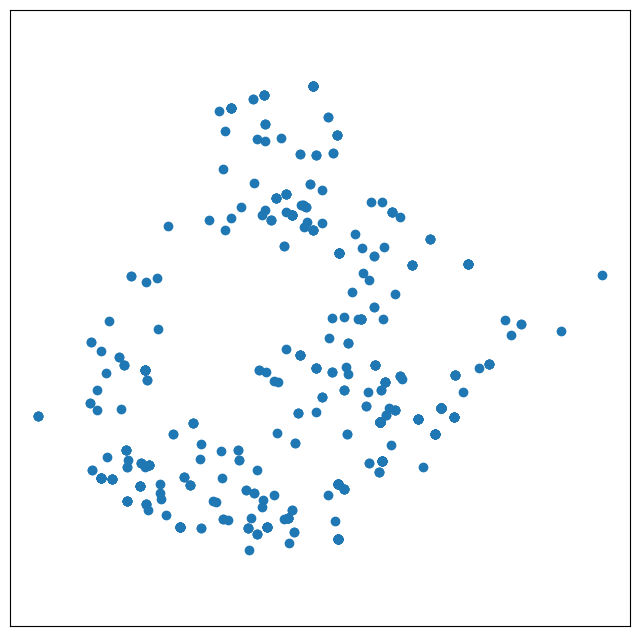

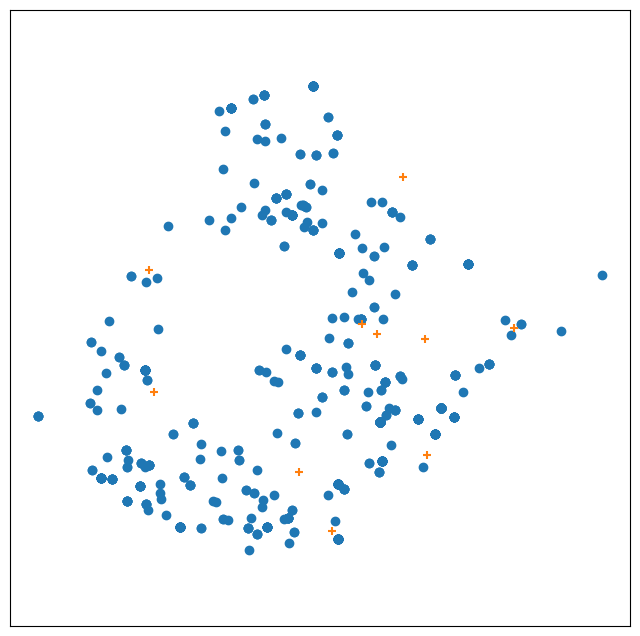

In [121]:
# Plot input data
plot_input(points)

# Number of sites to select
K = 10

# Service radius of each site
radius = 0.2

# Candidate site size (random sites generated)
M = 10

# Run mclp opt_sites is the location of optimal sites and f is the points covered
opt_sites,f = mclp(points,K,radius,M)

# Plot the result
plot_result(points,opt_sites,radius)

In [122]:
opt_sites

array([[127.08784813,  37.52944431],
       [127.09604725,  37.53600668],
       [127.09040259,  37.54730155],
       [127.09398241,  37.56004971],
       [127.10354094,  37.54696052],
       [127.0723815 ,  37.54143852],
       [127.09589147,  37.54606237],
       [127.09166868,  37.54643587],
       [127.08499128,  37.53456143],
       [127.07199481,  37.55198171]])